In [173]:
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt 
import numpy as np
import matplotlib as mpl
import geopandas as gpd
import os

In [35]:
import warnings 
warnings.filterwarnings( "ignore" )

In [36]:
os.listdir()

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'Code',
 'Datasets',
 'data_download.py',
 'dat_new.csv',
 'Resources',
 'risk_state_wave_anova.csv',
 'tests',
 'Untitled Folder',
 'Untitled.ipynb',
 'WPR']

In [37]:
dat = pd.read_csv("./Datasets/COVID-19 Cases(14-03-2022).csv", parse_dates = ["Date"], dayfirst = True, index_col = "S. No.")

In [38]:
dat = dat[[x.year >= 2020 for x in dat["Date"]]].fillna(0)
dat = dat[dat["Region"] != "World"]
dat = dat[dat["Region"] != "State assignment pending"]
dat = dat[dat["Region"] != "India"]
#dat["Region"] = dat["Region"]
dat["Year"] = [x.year for x in dat["Date"]]
dat["Month"] = [x.month for x in dat["Date"]]
dat.head()

,Date,Region,Confirmed Cases,Active Cases,Cured/Discharged,Death,Year,Month
S. No.,,,,,,,,
716,2020-03-27,Andaman and Nicobar Islands,1,1.0,0.0,0.0,2020,3
717,2020-03-28,Andaman and Nicobar Islands,6,6.0,0.0,0.0,2020,3
718,2020-03-29,Andaman and Nicobar Islands,9,9.0,0.0,0.0,2020,3
719,2020-03-30,Andaman and Nicobar Islands,9,9.0,0.0,0.0,2020,3
720,2020-03-31,Andaman and Nicobar Islands,10,10.0,0.0,0.0,2020,3


# severity per wave

In [39]:
#waves data
w_dates = {1:(2021, 2), 2:(2021, 12)}

dat["wave"] = [
    
 1 if (x[0], x[1]) <= w_dates[1] else 
 2 if (x[0], x[1]) <= w_dates[2] else 
 3
    
 for x in dat[["Year", "Month"]].values]

In [40]:
dat_w = dat.groupby(["wave", "Region"], as_index = False).sum().drop(["Confirmed Cases", "Year", "Month"], axis = 1)
dat_w["closed_cases"] = dat_w["Cured/Discharged"] + dat_w["Death"]
dat_w["p_death"] = (dat_w["Death"] / dat_w["closed_cases"]).fillna(0)
dat_w.head()

,wave,Region,Active Cases,Cured/Discharged,Death,closed_cases,p_death
0,1,Andaman and Nicobar Islands,49128.0,800299.0,11121.0,811420.0,0.013706
1,1,Andhra Pradesh,8244503.0,142548608.0,1257288.0,143805896.0,0.008743
2,1,Arunachal Pradesh,233687.0,2346388.0,7513.0,2353901.0,0.003192
3,1,Assam,2891271.0,35103619.0,166321.0,35269940.0,0.004716
4,1,Bihar,2299482.0,40767650.0,232114.0,40999764.0,0.005661


In [41]:
dat_w_g = dat_w[["wave", "Region", "p_death"]].groupby(["wave", "Region"], as_index = True).sum()*100
dat_w_g.head()

p_death
wave Region                               
1    Andaman and Nicobar Islands  1.370560
     Andhra Pradesh               0.874295
     Arunachal Pradesh            0.319172
     Assam                        0.471566
     Bihar                        0.566135

In [42]:
shp_gdf = gpd.read_file('./Datasets/india_geo_plot/India States/Indian_states.shp')
shp_gdf["st_nm"] = shp_gdf["st_nm"].str.replace('&','and')
shp_gdf["st_nm"] = shp_gdf["st_nm"].str.replace('Island','Islands')
shp_gdf["st_nm"] = shp_gdf["st_nm"].str.replace('NCT of ','')
shp_gdf["st_nm"] = shp_gdf["st_nm"].str.replace('Arunanchal','Arunachal')
shp_gdf["st_nm"] = shp_gdf["st_nm"].str.replace('Dadara and Nagar Havelli','Dadra and Nagar Haveli and Daman and Diu')

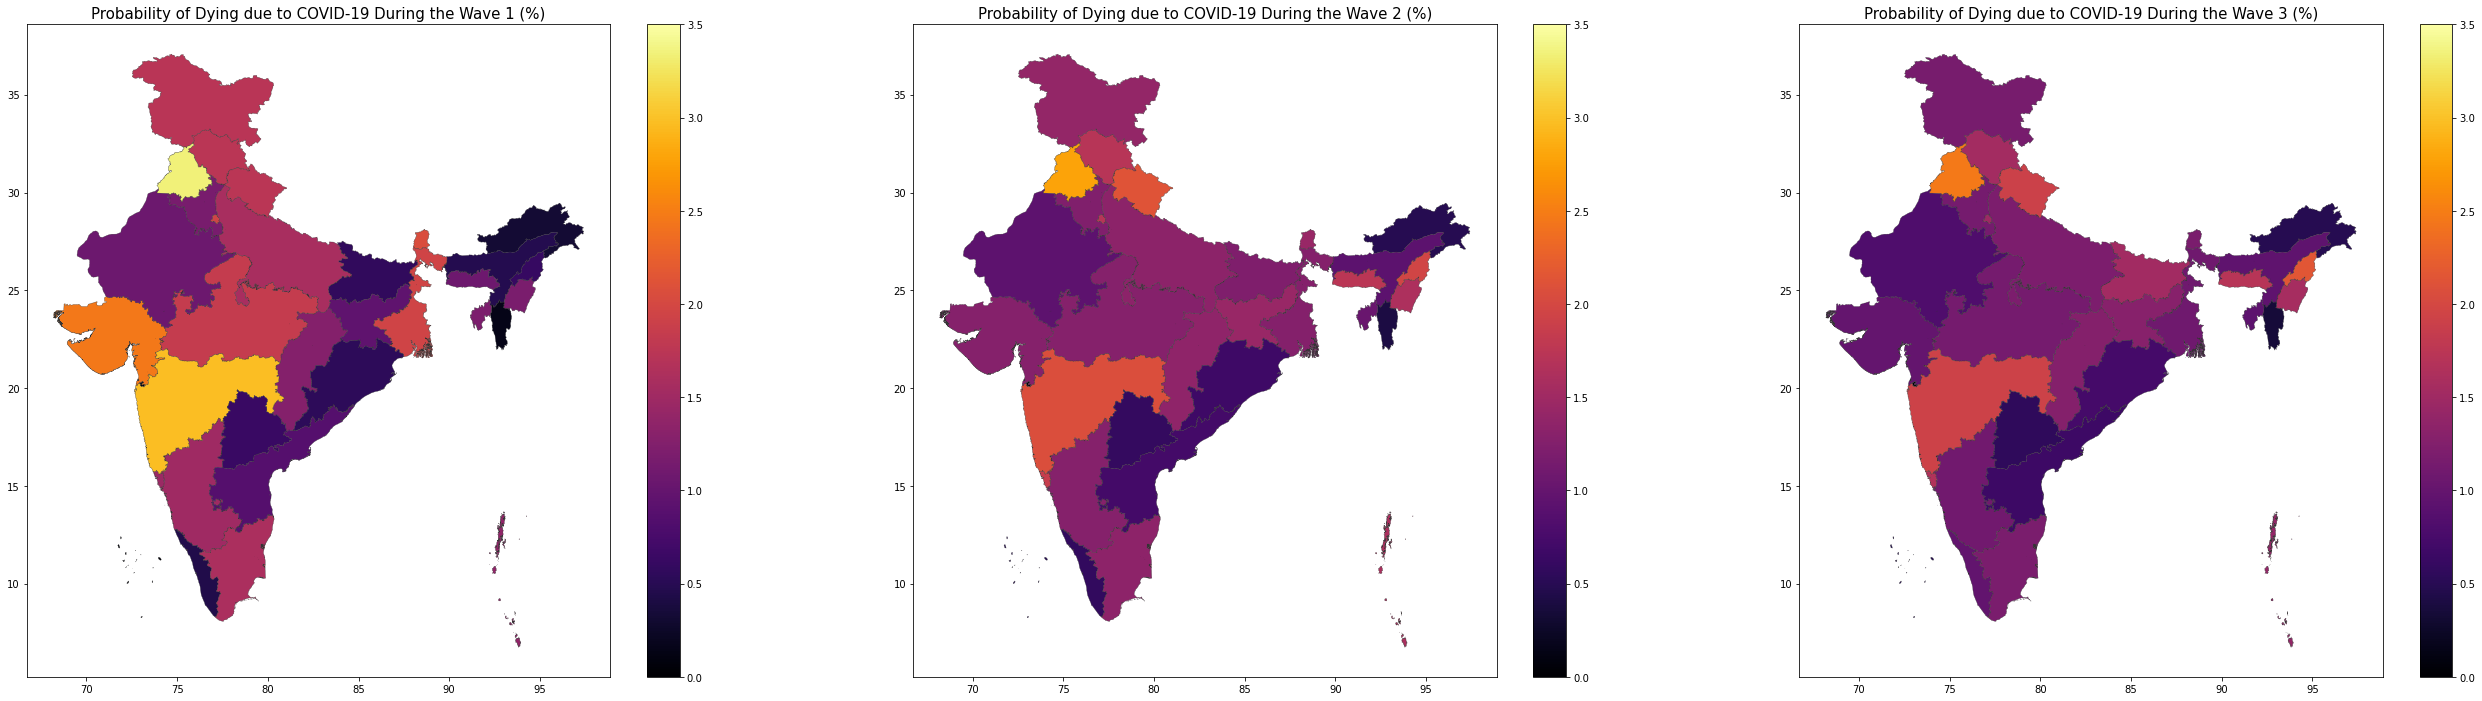

In [43]:
fig, axis = plt.subplots(nrows = 1, ncols = 3, figsize=(45, 12))
for i, ax in enumerate(axis):
    merged = shp_gdf.set_index('st_nm').join(dat_w_g.loc[i+1].drop("Ladakh")).fillna(0)
    ax.set_title('Probability of Dying due to COVID-19 During the Wave %i (%%)'%(i+1),
             fontdict={'fontsize': '15', 'fontweight' : '3'})
    fig = merged.plot(column='p_death', cmap='inferno', linewidth=0.3, ax=ax, edgecolor='0.2',legend = True, vmin = 0, vmax = 3.5)

In [44]:
dat_w_g.reset_index(level=1).head()

,Region,p_death
wave,,
1,Andaman and Nicobar Islands,1.370560
1,Andhra Pradesh,0.874295
1,Arunachal Pradesh,0.319172
1,Assam,0.471566
1,Bihar,0.566135


In [45]:
dat_aov = dat_w_g.reset_index(level=1).pivot(columns = "Region", values = "p_death")
dat_aov

Region,Andaman and Nicobar Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Dadra and Nagar Haveli and Daman and Diu,Delhi,Goa,...,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
wave,,,,,,,,,,,,,,,,,,,,,
1,1.370560,0.874295,0.319172,0.471566,0.566135,1.665759,1.259996,0.073493,1.952981,1.462944,...,1.831880,3.347313,1.056360,2.052008,1.609408,0.636852,1.195658,1.585738,1.741648,1.947961
2,1.600137,0.711734,0.488393,0.916732,1.221809,1.332992,1.359104,0.041272,1.717729,1.846143,...,1.514243,2.775412,0.938661,1.445757,1.348572,0.594765,1.027533,1.330047,2.123554,1.264080
3,1.400949,0.663679,0.479861,0.944474,1.528769,1.367647,1.264758,0.035858,1.477550,1.665270,...,1.281755,2.461177,0.814169,1.176953,1.189302,0.552931,0.935811,1.202753,1.903953,1.087824


<AxesSubplot:xlabel='wave'>

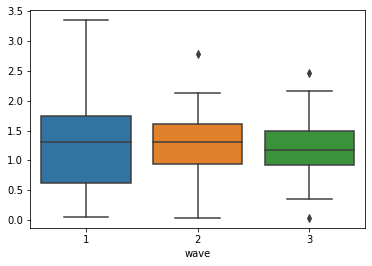

In [64]:
sns.boxplot(data = dat_aov.T)

Text(0.5, 0, 'p_death (in sd)')

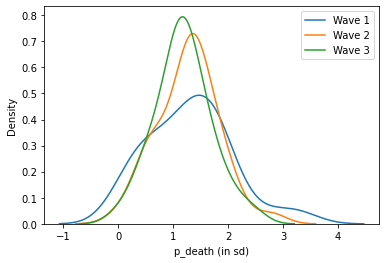

In [46]:
sns.distplot(dat_aov.iloc()[0], kde = True, hist = False)
sns.distplot(dat_aov.iloc()[1], kde = True, hist = False)
sns.distplot(dat_aov.iloc()[2], kde = True, hist = False)
plt.legend(["Wave 1", "Wave 2", "Wave 3"])
plt.xlabel("p_death (in sd)")

## Two Factor ANOVA for severity (wave vs Region)

In [47]:
from tests.anova import two_way as tw

In [48]:
p1, p2, o = tw(dat_aov)
#print(o.fillna(""))
o.to_csv("risk_state_wave_anova.csv")

            N Degrees of Freedom Sum of Squares   F Ratio   p-value
        108.0                                                      
row                          2.0       0.267648  0.037306  0.963401
column                      35.0      33.301562  4.641712       0.0
error                       70.0       7.174413                    
total                      107.0      40.743623                    


# overall statewise severity 

In [65]:
dat_m = dat.groupby(["Year", "Month", "Region"], as_index = False).sum().drop(["Confirmed Cases", "wave"], axis = 1)
dat_m["closed_cases"] = dat_m["Cured/Discharged"] + dat_m["Death"]
dat_m["p_death"] = (dat_m["Death"] / dat_m["closed_cases"]).fillna(0)*100
dat_m.head()

,Year,Month,Region,Active Cases,Cured/Discharged,Death,closed_cases,p_death
0,2020,3,Andaman and Nicobar Islands,35.0,0.0,0.0,0.0,0.0
1,2020,3,Andhra Pradesh,144.0,6.0,0.0,6.0,0.0
2,2020,3,Bihar,52.0,0.0,10.0,10.0,100.0
3,2020,3,Chandigarh,78.0,0.0,0.0,0.0,0.0
4,2020,3,Chhattisgarh,42.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'risk of death')

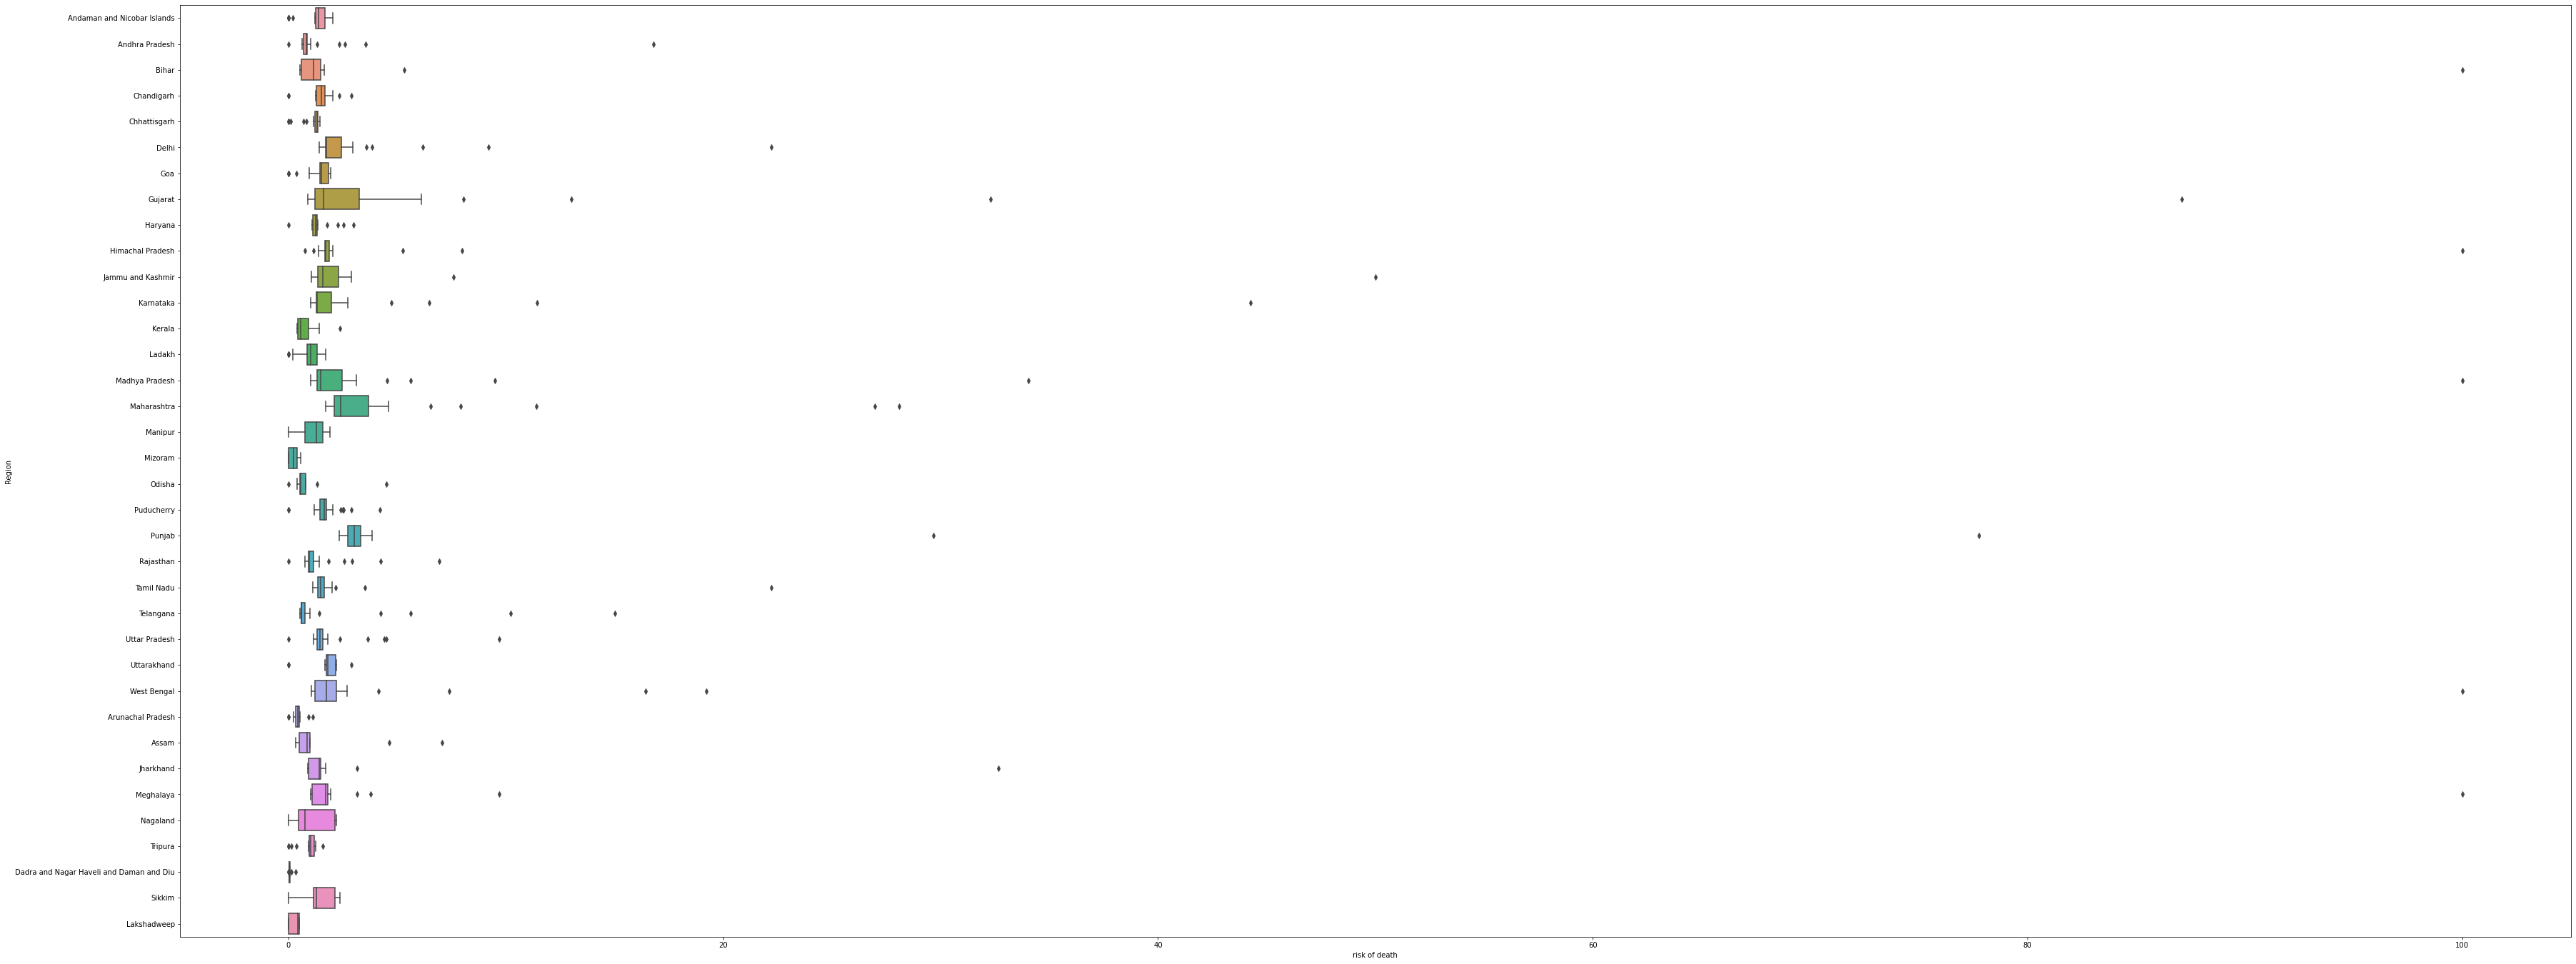

In [92]:
plt.figure(figsize = [60, 24])
bxp = sns.boxplot(data = dat_m, x = "p_death", y = "Region")
plt.xlabel("risk of death")

In [98]:
#remove outliers
dat_r = dat_m.pivot(index = ["Year", "Month"], columns = "Region", values = "p_death").fillna(0).reset_index().drop(["Year", "Month"], axis = 1)
cols = dat_r.columns
dat_r.head()

Region,Andaman and Nicobar Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Dadra and Nagar Haveli and Daman and Diu,Delhi,Goa,...,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telangana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
0,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,0.000000,22.222222,0.000000,...,0.000000,77.777778,0.000000,0.000000,22.222222,15.000000,0.000000,0.000000,0.000000,100.000000
1,0.000000,16.790736,0.000000,7.067138,5.315204,0.000000,0.000000,0.000000,9.207951,0.000000,...,0.000000,29.654591,6.918449,0.000000,3.505569,10.215537,0.000000,9.697733,0.000000,16.424581
2,0.000000,3.538711,0.000000,4.641350,1.595417,2.886516,0.113701,0.000000,3.836998,0.000000,...,2.898551,3.367618,4.249693,0.000000,1.625514,4.246735,0.000000,4.407757,2.882353,19.229123
3,0.000000,2.591218,1.128668,0.314087,0.962712,1.858185,0.805028,0.000000,6.168394,0.361582,...,4.198473,2.994531,2.933723,0.000000,1.995984,5.632769,0.138294,4.492749,1.971391,7.385813
4,0.209589,2.335066,0.924519,0.317147,1.076729,2.047392,0.676585,0.326358,3.575423,0.964350,...,2.488310,3.513544,2.565582,0.128576,2.172569,1.407728,0.352066,3.656691,1.708959,4.133096


In [102]:
Q1 = dat_r[cols].quantile(0.25)
Q3 = dat_r[cols].quantile(0.75)
IQR = Q3 - Q1
IQR = dict(IQR)
Q1 = dict(Q1)
Q3 = dict(Q3)

In [119]:
len([x.Region for x in dat_m.iloc])

886

In [123]:
dat_m_f = dat_m[[~((x.p_death < Q1[x.Region] - 1.5 *IQR[x.Region])|(x.p_death > Q3[x.Region] + 1.5 *IQR[x.Region])) for x in dat_m.iloc]]
dat_m_f.head()

,Year,Month,Region,Active Cases,Cured/Discharged,Death,closed_cases,p_death
16,2020,3,Manipur,7.0,0.0,0.0,0.0,0.000000
17,2020,3,Mizoram,6.0,0.0,0.0,0.0,0.000000
42,2020,4,Kerala,5446.0,5941.0,82.0,6023.0,1.361448
46,2020,4,Manipur,25.0,32.0,0.0,32.0,0.000000
48,2020,4,Mizoram,30.0,0.0,0.0,0.0,0.000000


Text(0.5, 0, 'risk of death')

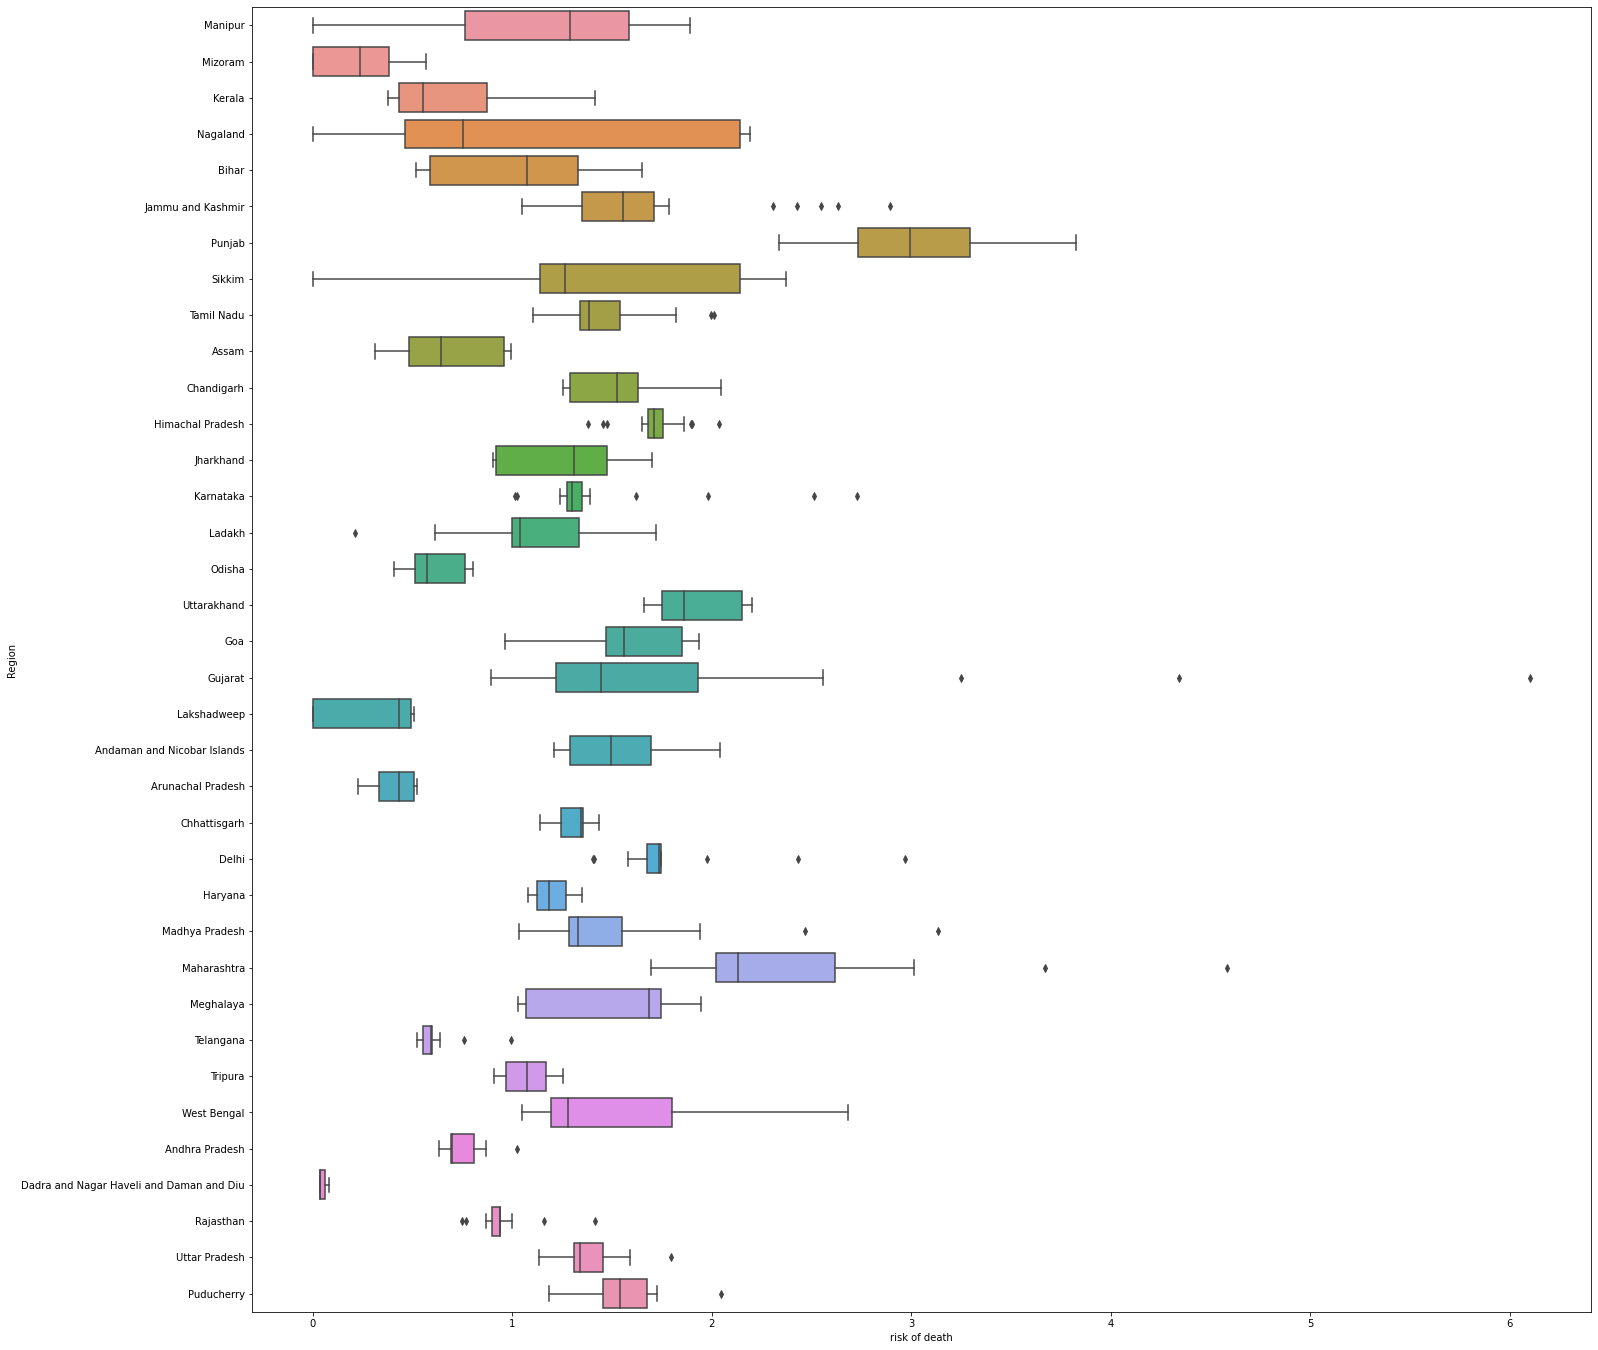

In [125]:
plt.figure(figsize = [24, 24])
bxp = sns.boxplot(data = dat_m_f, x = "p_death", y = "Region")
plt.xlabel("risk of death")

In [138]:
import plotly.express as px

In [238]:
regions = dat_m_f.Region.unique()

In [260]:
#region code 
r_code = dict([[x, len(regions) - i -1] for i, x in enumerate(regions)])
code_r = dict([[len(regions) - i -1, x] for i, x in enumerate(regions)])

In [261]:
code_r

{35: 'Manipur',
 34: 'Mizoram',
 33: 'Kerala',
 32: 'Nagaland',
 31: 'Bihar',
 30: 'Jammu and Kashmir',
 29: 'Punjab',
 28: 'Sikkim',
 27: 'Tamil Nadu',
 26: 'Assam',
 25: 'Chandigarh',
 24: 'Himachal Pradesh',
 23: 'Jharkhand',
 22: 'Karnataka',
 21: 'Ladakh',
 20: 'Odisha',
 19: 'Uttarakhand',
 18: 'Goa',
 17: 'Gujarat',
 16: 'Lakshadweep',
 15: 'Andaman and Nicobar Islands',
 14: 'Arunachal Pradesh',
 13: 'Chhattisgarh',
 12: 'Delhi',
 11: 'Haryana',
 10: 'Madhya Pradesh',
 9: 'Maharashtra',
 8: 'Meghalaya',
 7: 'Telangana',
 6: 'Tripura',
 5: 'West Bengal',
 4: 'Andhra Pradesh',
 3: 'Dadra and Nagar Haveli and Daman and Diu',
 2: 'Rajasthan',
 1: 'Uttar Pradesh',
 0: 'Puducherry'}

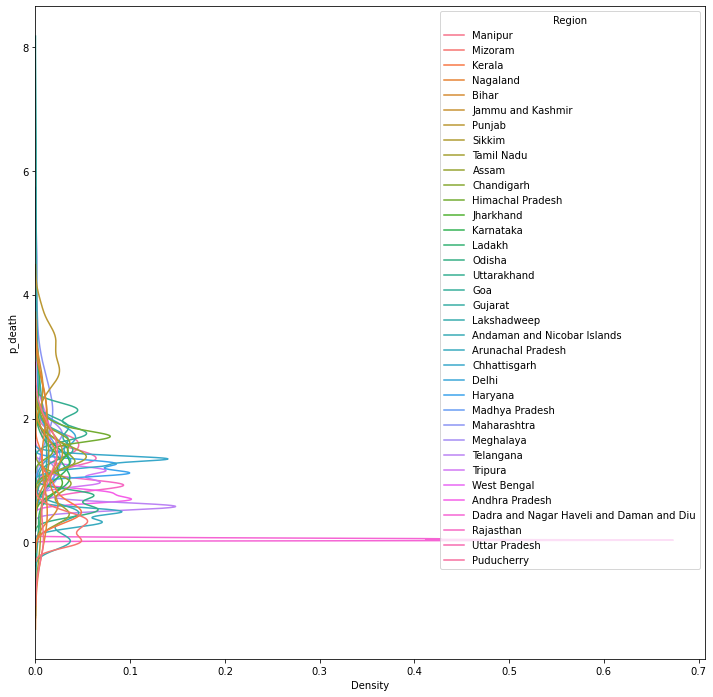

In [262]:
plt.figure(figsize = [12, 12])
kdp = sns.kdeplot(data = dat_m_f, y = "p_death", hue = "Region")

In [263]:
line_dat = [x.get_data() for x in kdp.get_lines()]

In [264]:
points = []

In [265]:
for i, v in enumerate(line_dat):
    z = np.ones(v[0].shape) * i
    for e in zip(z.astype(int), v[0], v[1]):
        points.append(e)

In [266]:
points_df = pd.DataFrame(points)
points_df["Region"] = [code_r[int(x[0])] for x in points_df.iloc]
points_df.columns = [' ', 'Density', 'Risk', "Region"]
points_df.head()

,,Density,Risk,Region
0,0,0.000083,0.846914,Puducherry
1,0,0.000103,0.854639,Puducherry
2,0,0.000126,0.862365,Puducherry
3,0,0.000153,0.870091,Puducherry
4,0,0.000186,0.877817,Puducherry


In [267]:
fig = px.line_3d(points_df, x = " ", z = "Density", y = "Risk", color = "Region")
fig.update_layout(title = "Distribution of Risk of Death Due to COVID-19 Per Region")
fig.show()
fig.write_html("risk_dist_region.html")